<center>
<h4>Diplomatura AACSyA 2018 - FaMAF - UNC</h4>
<h1>Aprendizaje No Supervisado</h1>
<h2>Práctico 2 - Sistemas de recomendación</h2>
<hr>
Por David Gonzalez <leonardo.david.gonzalez@gmail.com> y Facundo Díaz Cobos <facundo.diaz.cobos@gmail.com>
</center>
<br/>


# Objetivos

En este práctico tendrán que integrar en la notebook el sistema de recomendación basado en contenido que se propone en http://nbviewer.jupyter.org/github/khanhnamle1994/movielens/blob/master/Content_Based_ and_Collaborative_Filtering_Models.ipynb.

# Entrega

Entregar un notebook documentado a través de slack, antes del día 7 de septiembre.

___
# Sistema de Recomendación MovieLens


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import read_and_save_ratings_movies_users
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS


## Generamos los archivos csv a partir de los .dat

Los datos originales pertenecen al sitio MovieLens, este dataset contiene 1000209 calificaciones de 3900 peliculas hechas por 6040 usuarios en el año 2000. Los datos originales estan en trees archivos .dat, por lo que es necesario transformarlos a archivos csv (archivos separados por coma)

In [2]:
# Generar los archivos csv a partir de los .dat de movies users y rating
read_and_save_ratings_movies_users()

Saved to ratings.csv
6040 descriptions of 6040 users loaded.
Saved to users.csv
3883 descriptions of 3952 movies loaded.
Saved to movies.csv


In [3]:
# Leer los archivos csv
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

## Exploramos los tres archivos
### Calificaciones / ratings:

Podemos obvservar que las calificaciones son super simples, una columna para el usuario una para la pelicula y una calificacion del 1 al 5.

In [4]:
# Check the top 5 rows
print(ratings.head())

   user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5


### Usuarios:
Los usuarios tienen 5 features, un ID unico, un genero (F / M) un código postal una rango etario y una ocupación.

In [5]:
# Check the top 5 rows
print(users.head())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer


### Peliculas:
Las peliculas tienen tres features, un ID unico, un titulo y una lista de géneros separados por el caracter cañeria / pipe ( | ) Los generos son 18 (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western)


In [6]:
# Check the top 5 rows
print(movies.head())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


# Exploración de Datos
## Títulos
Creamos una nube de palabras para ver que Palabras se repiten más en los títulos de las peliculas

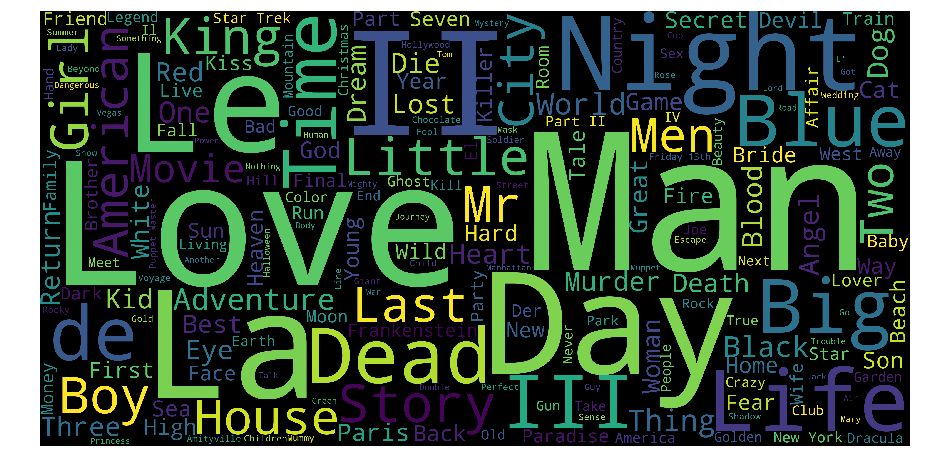

In [7]:
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Se pueden apreciar los titulos mas comunes, obviamente aparecen II y III como palabras
### Ratings
Ahora Analizamos la distribucion de los ratings

In [8]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


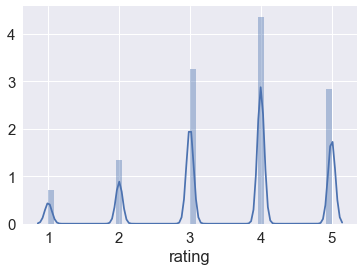

In [9]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

Podemos obvservar que la mayoria voto con 4, seguidos de 3 y 5. Muy pocos votaron con 1 y 2. No esta distribuido uniformemente, ni normalmente.
### Géneros de las películas
Los géneros seguramente serán importantes al construir los motores de recomendación ya que describe el contenido de la película. Una suposición básica es que las películas del mismo género deben tener contenidos similares. 
Vamos a mostrar en una tabla cuales son los generos mas populares de las peliculas

In [10]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

Vemos como Drama, Comedia y Accion son los generos mas populares, ahora hacemos una nube de palabras para graficarlo

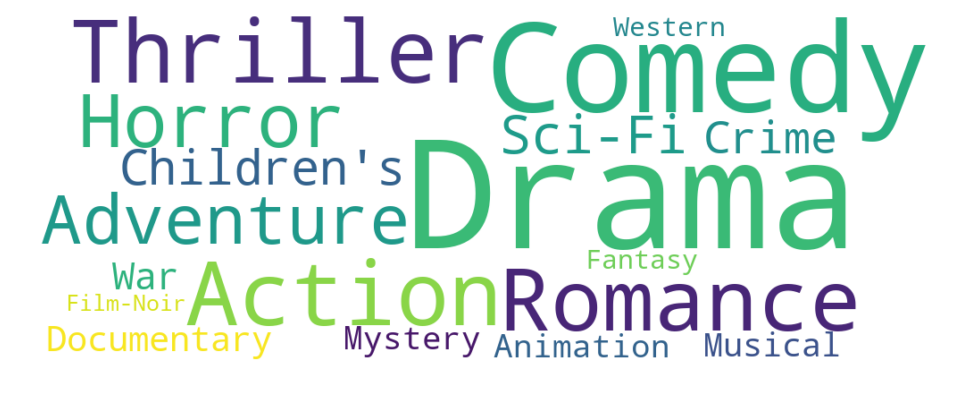

In [11]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Hay 2 Tipos de motores de recomendación

### 1. Basados en contenido

El recomendador basado en el contenido se basa en la similitud de los elementos que se recomiendan. La idea básica es que si te gusta un artículo, también te gustará un artículo "similar". Por lo general, funciona bien cuando es fácil determinar el contexto / propiedades de cada elemento.

Un recomendador basado en contenido funciona con datos que el usuario proporciona, en este caso las clasificaciones de las peliculas de MovieLens. En función de esos datos, se genera un perfil de usuario, que luego se utiliza para hacer sugerencias al usuario de nuevas pelicuas. A medida que el usuario proporciona más calificaciones, el motor se vuelve cada vez más preciso.

### 2. Filtrado colaborativo

El "Collaborative Filtering Recommender" se basa completamente en el comportamiento pasado y no en el contexto. Más específicamente, se basa en la similitud de preferencias, gustos y elecciones de dos usuarios. Analiza cuán similares son los gustos de un usuario a otro y hace recomendaciones sobre la base de eso.

Por ejemplo, si al usuario A le gustan las películas 1, 2, 3 y al usuario B le gustan las películas 2,3,4, entonces tienen intereses similares y A debería gustarle a la película 4 y B debería gustarle la película 1. 

En general, el filtrado colaborativo es el caballo de batalla de los motores de recomendación. El algoritmo tiene una propiedad muy interesante de poder hacer el aprendizaje de características por sí mismo, lo que significa que puede comenzar a aprender por sí mismo qué características usar. 

Se puede dividir en  Filtrado colaborativo basado en memoria  y  Filtrado colaborativo basado en modelo.

![rec-systems](images/rec-systems.png)


## Modelo de recomendación basado en el contenido

### Teoría

Los conceptos de Frecuencia de término (TF) y Frecuencia inversa de documento (IDF)
se utilizan en sistemas de información y también en mecanismos de filtrado basados
en contenido (como un recomendador basado en contenido).
Se usan para determinar la importancia relativa de un documento / artículo / noticia / película, etc.

TF es simplemente la frecuencia de una palabra en un documento. 
IDF es la inversa de la frecuencia del documento entre todo el corpus de documentos. 
TF-IDF se utiliza principalmente por dos motivos: supongamos que buscamos 
    
"** los resultados de los últimos juegos europeos de Futbol **" en Google.

Es cierto que las palabras como "el", "los", "de" ocurrirán con más frecuencia que "** juegos europeos de Futbol **" 
pero la importancia relativa de ** juegos europeos de Futbol ** es más alta que el punto de vista de la búsqueda.
En tales casos, la ponderación TF-IDF niega el efecto de las palabras de alta frecuencia para determinar 
la importancia de un elemento (documento).



### Implementación del un Montor de Recomendacion basado en contenido.


In [12]:
# Primero descompone el arreglo de generos separados por el caracter pipeline en un arreglo de strings de generos
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [13]:
# Usamos la funcion de sklearn de tokenvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

Utilizamos la Similitud coseno para calcular una cantidad numérica que denote la similitud entre dos películas. Ya que hemos utilizado el Vectorizador TF-IDF, al calcular el Producto Punto, nos dará directamente el Puntaje de Similaridad. Utilizaremos kernel lineal de sklearn.

In [14]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

Tenemos ahora la matriz de similitud de coseno de los pares. El siguiente paso es escribir una función que devuelva las 20 películas más similares en función de la puntuación de similitud del coseno.

In [15]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

### Y eso seria todo en realidad, lo complicado es obtener la matriz
Probemos con una pelicula para niños y obtengamos las mejores recomendaciones para algunas películas y veamos qué tan buenas son las recomendaciones.

In [16]:
genre_recommendations('Toy Story (1995)').head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

Parece que funciono bastante bien!!!
Si bien no conocemos todas las pelicuas que devolvió las que so lo hizo son peliculas de dibujitos animados!

In [17]:
genre_recommendations('Full Metal Jacket (1987)').head(20) 

461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat, The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
1959      Saving Private Ryan (1998)
2358       Thin Red Line, The (1998)
2993         Longest Day, The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees, The (1944)
3585    Guns of Navarone, The (1961)
3684             Patriot, The (2000)
40                Richard III (1995)
153            Beyond Rangoon (1995)
332         Walking Dead, The (1995)
523          Schindler's List (1993)
641        Courage Under Fire (1996)
967          Nothing Personal (1995)
979           Michael Collins (1996)
1074                  Platoon (1986)
Name: title, dtype: object

Lo mismo acá, que deberian ser peliculas de guerra o accion.

En general, aquí están las ventajas de usar recomendaciones basadas en el contenido:
* No hay necesidad de datos sobre otros usuarios, por lo tanto, no hay problemas de arranque en frío o escasez.
* Puede recomendar a los usuarios con gustos únicos.
* Puede recomendar artículos nuevos e impopulares.
* Puede proporcionar explicaciones para los artículos recomendados al enumerar las características del contenido que causaron que un artículo sea recomendado (en este caso, géneros de películas)

Sin embargo, hay algunos contras de usar este enfoque:
* Encontrar las características apropiadas es difícil.
* No recomienda elementos fuera del perfil de contenido de un usuario.
* Incapaz de explotar los juicios de calidad de otros usuarios.

__

## Collaborative Filtering Recommendation Model

El motor basado en contenido sufre algunas limitaciones severas:

Solo es capaz de sugerir películas que están cerca de una determinada película. Es decir, no es capaz de capturar los gustos y proporcionar recomendaciones en todos los géneros.

Además, el motor que construimos no es realmente personal ya que no captura los gustos personales y los prejuicios de un usuario. Cualquiera que consulte el motor para obtener recomendaciones basadas en una película recibirá las mismas recomendaciones para esa película, independientemente de quién sea.

La técnica se basa en la idea de que usuarios similares a mí, se pueden usar para predecir cuánto me gustará un producto o servicio en particular que esos usuarios hayan usado / experimentado anteriormente...


### Teoría
Existen 2 tipos principales de algoritmos de filtrado colaborativo basados

1. ** Filtrado colaborativo usuario-usuario ** : Aquí encontramos usuarios parecidos en función de la similitud y recomendamos películas que el primer usuario similar ha elegido en el pasado. Este algoritmo es muy efectivo pero requiere mucho tiempo y recursos. Requiere calcular cada par de usuario información que lleva tiempo. 


2. ** Filtrado colaborativo de elementos de artículos ** : es bastante similar al algoritmo anterior, pero en lugar de buscar el aspecto similar del usuario, tratamos de encontrar el aspecto de la película. Una vez que tengamos la matriz parecida a la de la película, podemos recomendar fácilmente películas similares para el usuario que haya calificado cualquier película del conjunto de datos. Este algoritmo consume mucho menos recursos que el filtro colaborativo usuario-usuario. Por lo tanto, para un nuevo usuario, el algoritmo tarda mucho menos tiempo que el usuario colaborador, ya que no necesitamos todos los puntajes de similitud entre los usuarios. Y con una cantidad fija de películas, la matriz similar a la película de película se repara con el tiempo.



En cualquier escenario, construimos una matriz de similitud. Para el filtrado colaborativo del usuario-usuario, la ** matriz de similitud del usuario ** consistirá en algunas medidas de distancia que miden la similitud entre dos pares de usuarios. Del mismo modo, la ** matriz de similitud de elementos ** medirá la similitud entre dos pares de elementos.

Hay 3 métricas de similitud de distancia que generalmente se utilizan en el filtrado colaborativo:
1. ** Similitud de Jaccard **:
    * La similitud se basa en el número de usuarios que han calificado el elemento A y B dividido por el número de usuarios que han calificado como A o B
    * Por lo general, se usa cuando no tenemos una calificación numérica, sino solo un valor booleano como un producto que se está comprando o un complemento al que se hace clic.

2. ** Similitud de coseno **: (como en el sistema basado en contenido)
    * La similitud es el coseno del ángulo entre los 2 vectores de los vectores de elementos de A y B
    * Más cerca de los vectores, más pequeño será el ángulo y más grande el coseno

3. ** Similitud de Pearson **:
    * La similitud es el coeficiente de Pearson entre los dos vectores.

Para propósitos de diversidad, usamos ** Pearson Similarity ** en esta implementación.

### Implementación
Utilizamos el archivo ** ratings.csv ** primero ya que contiene ID de usuario, ID de película y Calificaciones. Estos tres elementos son todo lo que necesito para determinar la similitud de los usuarios en función de sus calificaciones para una película en particular.


In [18]:
# Llenamos los campos vacios
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)
# Ponemos el average en los que no hay datos
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

In [19]:
# Randomly sample 2% of the ratings dataset
small_data = ratings.sample(frac=0.02)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 816325 to 597890
Data columns (total 3 columns):
user_id     20004 non-null int64
movie_id    20004 non-null int64
rating      20004 non-null int64
dtypes: int64(3)
memory usage: 625.1 KB
None


Ahora usamos ** la biblioteca scikit-learn ** para dividir el conjunto de datos en pruebas y entrenamiento. ** Cross_validation.train_test_split ** 

In [20]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(small_data, test_size=0.2)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Ahora necetiamos crear una matriz de elementos de usuario. Como he dividido los datos en pruebas y entrenamiento, necesito crear dos matrices. La matriz de entrenamiento contiene el 80% de las calificaciones y la matriz de prueba contiene el 20% de las calificaciones.

In [21]:
# Creamos las dos matrices, una para pruebas y la otra entrenamiento
train_data_matrix = train_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])
test_data_matrix = test_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16003, 3)
(4001, 3)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Ahora utilizo la función ** pairwise_distances ** de sklearn para calcular el [Coeficiente de correlación de Pearson](https://stackoverflow.com/questions/1838806/euclidean-distance-vs-pearson-correlation-vs-cosine-similarity). Este método proporciona una forma segura de tomar una matriz de distancia como entrada, preservando la compatibilidad con muchos otros algoritmos que toman una matriz vectorial.

In [22]:
from sklearn.metrics.pairwise import pairwise_distances

# La matriz de similitud de usuarios
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.959189   0.97708744 0.37377573]
 [0.959189   1.         0.9973949  0.09625094]
 [0.97708744 0.9973949  1.         0.16779998]
 [0.37377573 0.09625094 0.16779998 1.        ]]


In [23]:
# IY ahora la matriz de las calific
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.02259048  0.01012199]
 [-0.02259048  1.         -0.07633387]
 [ 0.01012199 -0.07633387  1.        ]]


Con la matriz de similitud, ahora podemos predecir las clasificaciones que no se incluyeron con los datos. Usando estas predicciones, puedo compararlas con los datos de prueba para intentar validar la calidad de nuestro modelo de recomendación.

Para el caso CF usuario usuario, veré la similitud entre 2 usuarios (A y B, por ejemplo) como pesos que se multiplican por las calificaciones de un usuario B similar (corregido para la calificación promedio de ese usuario). También necesito normalizarlo para que las calificaciones se mantengan entre 1 y 5 y, como paso final, sumar las calificaciones promedio para el usuario que intento predecir. La idea aquí es que algunos usuarios tienden a dar calificaciones altas o bajas a todas las películas. La diferencia relativa en las calificaciones que dan estos usuarios es más importante que los valores absolutos.

In [24]:
# Definimos la func de prediccion
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### Evaluación
Hay muchas métricas de evaluación, pero una de las métricas más utilizadas para evaluar la precisión de las clasificaciones es ** Error cuadrático medio  **. Utilizaré la función ** mean_square_error (MSE) ** de sklearn, donde el RMSE es solo la raíz cuadrada de MSE.

$$\mathit{RMSE} =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$

Usaré la función ** error cuadrático medio ** de scikit-learn como mi métrica de validación. Comparando el filtrado colaborativo basado en el usuario y el elemento, parece que el filtrado colaborativo basado en el usuario da un mejor resultado.

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function para calcular el Error cuadratico medio
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [26]:
# Ppredecimos sobre el conjunto de entremiento
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# Error cuadratico medio en el set de test
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1442.0758851735645
Item-based CF RMSE: 1660.2671014135085


In [28]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 695.4559189633868
Item-based CF RMSE: 185.12420207112658


RMSE de entrenamiento del modelo es una medida que mide la cantidad de señal y el ruido que explica el modelo. Noté que mi RMSE es bastante grande. Supongo que podría haber sobreajustado los datos de entrenamiento.

En general, el filtrado colaborativo basado en la memoria es fácil de implementar y produce una calidad de predicción razonable. Sin embargo, hay algunos inconvenientes de este enfoque:

* No soluciona el conocido problema de arranque en frío, es decir, cuando un usuario nuevo o un elemento nuevo ingresa al sistema.
* No puede tratar con datos dispersos, lo que significa que es difícil encontrar usuarios que hayan calificado los mismos elementos.
* Sufre cuando nuevos usuarios o artículos que no tienen ninguna clasificación ingresan al sistema.
* Tiende a recomendar artículos populares.